In [1]:
import os
import numpy as np
import scipy.stats as st
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rc('figure', dpi=160)
plt.rc('legend', fontsize=6)

In [2]:
def concatenate_results(dir_path):
    path = Path(dir_path)
    (_, dir_names, _) = next(os.walk(path))  # Get subdirectories
    memmaps = []
    for sweep_dir in [d for d in dir_names if d.startswith("sweep")]:  # Filter for "sweep" prefix
        # Open the performance memmaps in each subdirectory:
        memmaps.append(np.lib.format.open_memmap(str(path / sweep_dir / 'episodic_performance.npy'), mode='r'))
    concatenated = np.concatenate(memmaps)  # concatenate all memmaps together (note: loads them all into memory)
    performance_memmap = np.lib.format.open_memmap(str(path / 'concatenated_performance.npy'), shape=concatenated.shape, dtype=concatenated.dtype, mode='w+')
    performance_memmap[:] = concatenated
    del memmaps
    del concatenated
    del performance_memmap

def average_results(performance_memmap):
    results = performance_memmap['performance']['results']
    # Average results over evaluation runs:
    mean_eval_results = np.mean(results, axis=3)
    var_eval_results = np.var(results, axis=3)
    # Average results over ACE runs:
    mean_results = np.mean(mean_eval_results, axis=1)
    # Combine estimates of SEM correctly (We're sampling polices learned by the algorithms, then sampling the performance of these sampled policies, so the standard errors must be combined appropriately (https://stats.stackexchange.com/questions/231027/combining-samples-based-off-mean-and-standard-error)):
    num_configs, num_runs, num_policies, num_eval_runs = results.shape
    sem_results = np.sqrt(np.sum(var_eval_results / num_eval_runs, axis=1)) / num_runs
    return mean_results, sem_results

In [3]:
def create_label(p):
    return f'\n  {"OffPAC" if p["eta"] == 0. else "ACE"} \
\n  $\\alpha_a$:{p["alpha_a"]} \
\n  $\\alpha_w$:{p["alpha_w"]} \
\n  $\\alpha_v$:{p["alpha_v"]} \
\n  $\\lambda$:{p["lambda"]} \
\n  $\\eta$:{p["eta"]}'

In [4]:
# Load OffPAC results:
op_memmap = np.lib.format.open_memmap('/home/s/sutton/graves/scratch/actor-critic-with-emphatic-weightings/virtual-office/offpac/concatenated_performance.npy', mode='r')
op_results = op_memmap['performance']['results']
op_num_configs, op_num_runs, op_num_policies, op_num_eval_runs = op_results.shape
op_parameters = op_memmap['parameters']
op_mean_results, op_sem_results = average_results(op_memmap)
op_total_return = op_mean_results.sum(axis=1)

In [5]:
# Load ACE results:
ace_memmap = np.lib.format.open_memmap('/home/s/sutton/graves/scratch/actor-critic-with-emphatic-weightings/virtual-office/ace/concatenated_performance.npy', mode='r')
ace_results = ace_memmap['performance']['results']
ace_num_configs, ace_num_runs, ace_num_policies, ace_num_eval_runs = ace_results.shape
ace_parameters = ace_memmap['parameters']
ace_mean_results, ace_sem_results = average_results(ace_memmap)
ace_total_return = ace_mean_results.sum(axis=1)

Text(0, 0.5, 'Episode returns')

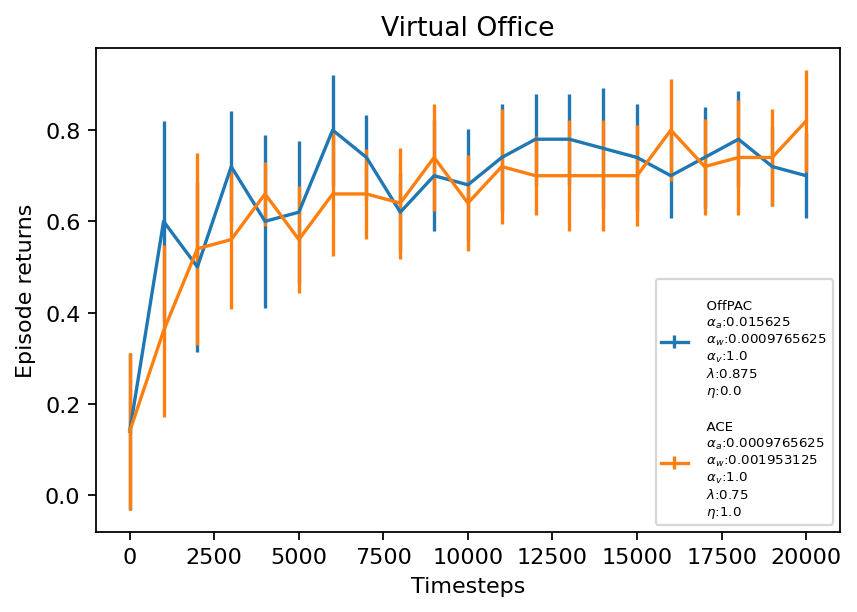

In [6]:
fig, ax = plt.subplots()

# Plot OffPAC results:
op_best_config = np.nanargmax(op_total_return)
x = op_memmap['performance']['timesteps'][0][0]
y = op_mean_results[op_best_config]
cis = op_sem_results[op_best_config] * st.t.ppf((1.0 + 0.95) / 2, op_num_eval_runs - 1)
label = create_label(op_parameters[op_best_config])
ax.errorbar(x, y, yerr=[cis, cis], label=label)

# Plot ACE results:
ace_best_config = np.nanargmax(ace_total_return)
x = ace_memmap['performance']['timesteps'][0][0]
y = ace_mean_results[ace_best_config]
cis = ace_sem_results[ace_best_config] * st.t.ppf((1.0 + 0.95) / 2, ace_num_eval_runs - 1)
label = create_label(ace_parameters[ace_best_config])
ax.errorbar(x, y, yerr=[cis, cis], label=label)

plt.legend(loc="lower right")
plt.title('Virtual Office')
plt.xlabel('Timesteps')
plt.ylabel('Episode returns')

Text(0, 0.5, 'Episode returns')

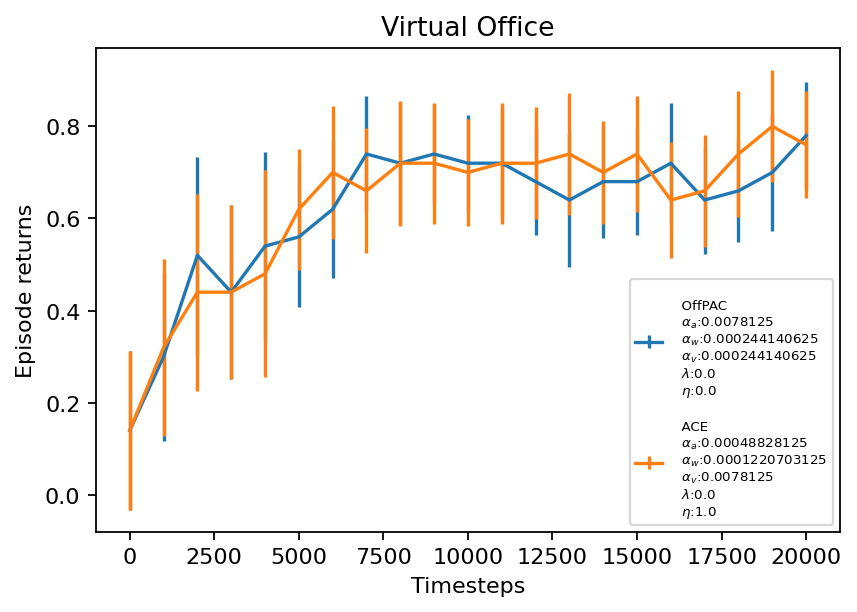

In [7]:
fig, ax = plt.subplots()

trace_decay_rate = 0.

# Plot OffPAC results:
op_mask = (op_parameters['lambda'] == trace_decay_rate)
op_best_config = np.nanargmax(op_total_return[op_mask])
x = op_memmap['performance']['timesteps'][0][0]
y = op_mean_results[op_mask][op_best_config]
cis = op_sem_results[op_mask][op_best_config] * st.t.ppf((1.0 + 0.95) / 2, op_num_eval_runs - 1)
label = create_label(op_parameters[op_mask][op_best_config])
ax.errorbar(x, y, yerr=[cis, cis], label=label)

# Plot ACE results:
ace_mask = (ace_parameters['lambda'] == trace_decay_rate)
ace_best_config = np.nanargmax(ace_total_return[ace_mask])
x = ace_memmap['performance']['timesteps'][0][0]
y = ace_mean_results[ace_mask][ace_best_config]
cis = ace_sem_results[ace_mask][ace_best_config] * st.t.ppf((1.0 + 0.95) / 2, ace_num_eval_runs - 1)
label = create_label(ace_parameters[ace_mask][ace_best_config])
ax.errorbar(x, y, yerr=[cis, cis], label=label)

plt.legend(loc="lower right")
plt.title('Virtual Office')
plt.xlabel('Timesteps')
plt.ylabel('Episode returns')

In [ ]:
# TODO: Visualize state/state-action visits.

In [ ]:
# Visualize a learned policy:
from src.algorithms.ace import LinearACE
import gym
import gym_virtual_office

env = gym.make('VirtualOffice-v0').unwrapped
env.seed(14)
rng = env.np_random

policies_memmap = np.lib.format.open_memmap('/home/s/sutton/graves/scratch/actor-critic-with-emphatic-weightings/virtual-office/offpac/sweep0/policies.npy', mode='r')
policy = policies_memmap[op_mask][op_best_config]['policies']['weights'][0][-1]
actor = LinearACE(*policy.shape, 0.)

# TODO: write code to create and display a video:
# o_t = env.reset()['image'].ravel()
# for t in range(1000):
#     a_t = rng.choice(env.action_space.n, p=actor.pi(o_t))
#     o_tp1, r_tp1, terminal, _ = env.step(a_t)
#     o_tp1 = o_tp1['image'].ravel()
#     o_t = o_tp1
#     if terminal:
#         break